In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
import yaml
import sys
from matplotlib import pyplot as plt

# Use direct imports to avoid __init__.py issues
sys.path.append('/home/licho/.programming/Projects/counterfactuals')

from counterfactuals.cf_methods.ppcef import PPCEF
from counterfactuals.datasets.base import DatasetParameters
from counterfactuals.datasets.moons import MoonsDataset
from counterfactuals.discriminative_models import MultilayerPerceptron
from counterfactuals.generative_models import MaskedAutoregressiveFlow
from counterfactuals.losses import BinaryDiscLoss
from counterfactuals.metrics import evaluate_cf

In [11]:
# Load YAML config and initialize dataset with new structure
with open("../config/datasets/moons.yaml", "r") as f:
    cfg_dict = yaml.safe_load(f)

config = DatasetParameters(**cfg_dict)
dataset = MoonsDataset(config=config)

print("✅ Dataset initialized")
print(f"Shape X: {dataset.X.shape}, Shape y: {dataset.y.shape}")

# Split data into train/test using the base class method
X_train, X_test, y_train, y_test = dataset.split_data(dataset.X, dataset.y)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

# Update dataset with split data
dataset.X_train = X_train
dataset.X_test = X_test  
dataset.y_train = y_train
dataset.y_test = y_test

# Create dataloaders manually using PyTorch
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                             torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                            torch.tensor(y_test, dtype=torch.float32))

train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

✅ Dataset initialized
Shape X: (1024, 2), Shape y: (1024,)
Train size: 819, Test size: 205


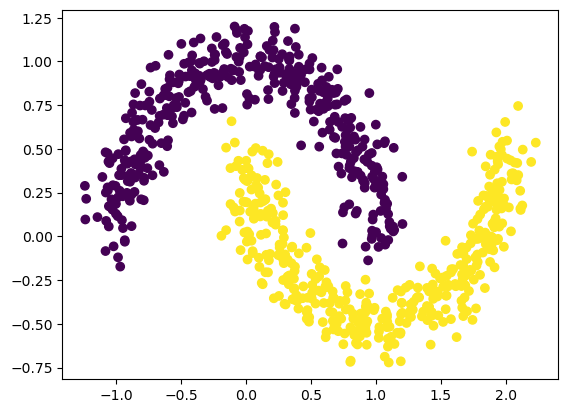

In [12]:
for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

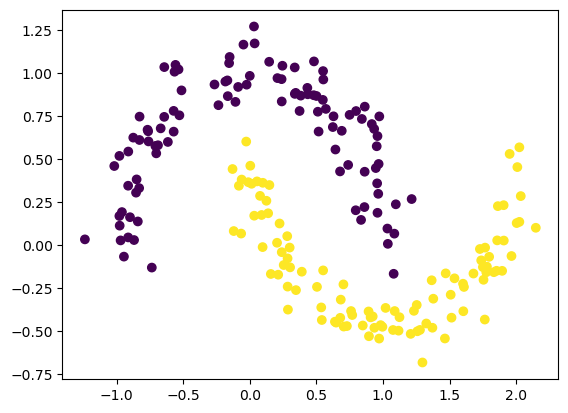

In [13]:
for X, y in test_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [14]:
# Create new dataloaders with different batch size for training
train_dataset_small = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                   torch.tensor(y_train, dtype=torch.float32))
test_dataset_small = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                                  torch.tensor(y_test, dtype=torch.float32))

train_dataloader = DataLoader(train_dataset_small, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset_small, batch_size=128, shuffle=False)

disc_model = MultilayerPerceptron(
    input_size=2, hidden_layer_sizes=[256, 256], target_size=1, dropout=0.2
)
disc_model.fit(
    train_dataloader,
    test_dataloader,
    epochs=5000,
    patience=300,
    lr=1e-3,
)
# disc_model.load("../models/MoonsDataset/disc_model_MultilayerPerceptron.pt")

Epoch 457, Train: 0.0143, test: 0.0142, patience: 300:   9%|▉         | 458/5000 [00:04<00:47, 96.45it/s] 


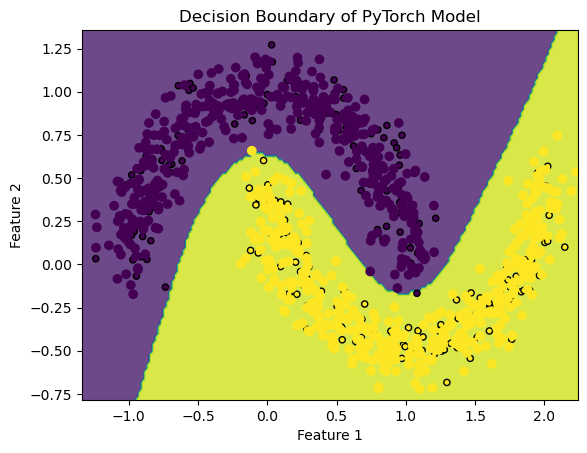

In [ ]:
import numpy as np

# Create a mesh grid for plotting decision boundaries
h = 0.02
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Make predictions on the grid points
disc_model.eval()
with torch.no_grad():
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = disc_model.predict(grid_points)
    Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k", s=20)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Decision Boundary of PyTorch Model")

for X, y in train_dataloader:
    plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [16]:
gen_model = MaskedAutoregressiveFlow(
    features=dataset.X.shape[1], hidden_features=8, context_features=1
)

# Create dataloader with noise for generative model training
train_dataset_gen = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                 torch.tensor(y_train, dtype=torch.float32))
gen_train_dataloader = DataLoader(train_dataset_gen, batch_size=1024, shuffle=True)

gen_model.fit(train_dataloader, test_dataloader, num_epochs=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 173, Train: 0.3621, test: 0.4184, patience: 20:  17%|█▋        | 173/1000 [00:04<00:19, 42.79it/s]


In [18]:
cf = PPCEF(
    gen_model=gen_model,
    disc_model=disc_model,
    disc_model_criterion=BinaryDiscLoss(),
)

# Create dataloader for counterfactual generation
cf_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                          torch.tensor(y_test, dtype=torch.float32))
cf_dataloader = DataLoader(cf_dataset, batch_size=1024, shuffle=False)

log_prob_threshold = torch.quantile(gen_model.predict_log_prob(cf_dataloader), 0.25)
deltas, X_orig, y_orig, y_target, logs = cf.explain_dataloader(
    cf_dataloader, alpha=100, log_prob_threshold=log_prob_threshold, epochs=4000
)

  0%|          | 0/4000 [00:00<?, ?it/s]

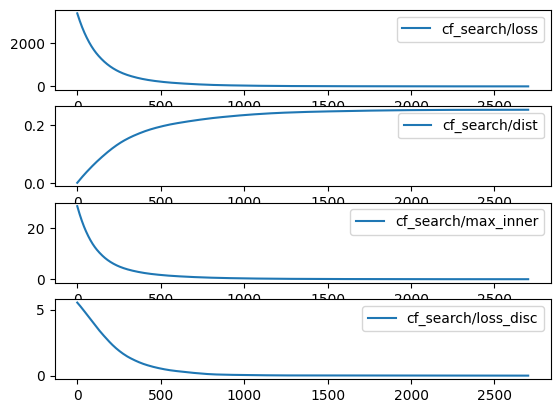

In [ ]:
for i, (log_name, log_vals) in enumerate(logs.items()):
    plt.subplot(len(logs), 1, i + 1)
    plt.plot(log_vals, label=log_name)
    plt.legend()

In [19]:
X_cf = X_orig + deltas

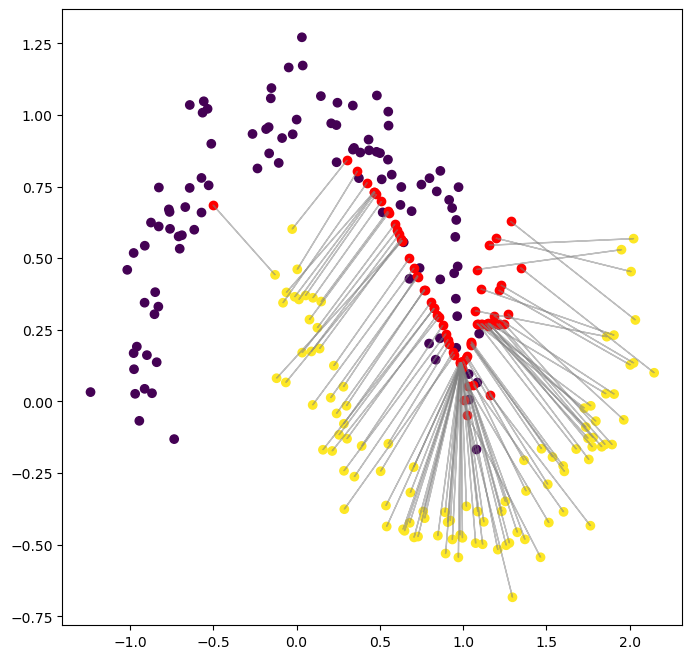

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))

i = y_orig.reshape(-1) == 1
ax.scatter(X_orig[:, 0], X_orig[:, 1], c=y_orig)
ax.scatter(X_orig[i, 0] + deltas[i, 0], X_orig[i, 1] + deltas[i, 1], c="r")
for before, after in zip(X_orig[i], X_cf[i]):
    ax.arrow(
        before[0],
        before[1],
        after[0] - before[0],
        after[1] - before[1],
        head_width=0.0,
        head_length=0.0,
        fc="gray",
        ec="gray",
        alpha=0.5,
        width=0.0001,
    )

In [22]:
evaluate_cf(
    disc_model=disc_model,
    gen_model=gen_model,
    X_cf=X_cf,
    model_returned=np.ones(X_cf.shape[0]),
    continuous_features=config.continuous_features,
    categorical_features=config.categorical_features,
    X_train=dataset.X_train,
    y_train=dataset.y_train,
    X_test=X_orig,
    y_test=y_orig,
    median_log_prob=log_prob_threshold,
    y_target=y_target,
)

2025-09-11 16:52:53,049 - counterfactuals.metrics.distances - INFO - Calculating combined distance
2025-09-11 16:52:53,049 - counterfactuals.metrics.distances - INFO - Calculating continuous distance
2025-09-11 16:52:53,049 - counterfactuals.metrics.distances - INFO - Calculating categorical distance
2025-09-11 16:52:53,050 - counterfactuals.metrics.distances - INFO - Calculating combined distance
2025-09-11 16:52:53,050 - counterfactuals.metrics.distances - INFO - Calculating continuous distance
2025-09-11 16:52:53,050 - counterfactuals.metrics.distances - INFO - Calculating categorical distance
2025-09-11 16:52:53,051 - counterfactuals.metrics.distances - INFO - Calculating combined distance
2025-09-11 16:52:53,051 - counterfactuals.metrics.distances - INFO - Calculating continuous distance
2025-09-11 16:52:53,051 - counterfactuals.metrics.distances - INFO - Calculating categorical distance
2025-09-11 16:52:53,051 - counterfactuals.metrics.distances - INFO - Calculating combined dist

{'coverage': 1.0,
 'validity': 1.0,
 'actionability': 0.0,
 'sparsity': 1.0,
 'proximity_categorical_hamming': nan,
 'proximity_categorical_jaccard': 0.706256710972269,
 'proximity_continuous_manhattan': 0.9440591073363931,
 'proximity_continuous_euclidean': 0.706256710972269,
 'proximity_continuous_mad': 1.8895174229863951,
 'proximity_l2_jaccard': 0.706256710972269,
 'proximity_mad_hamming': nan,
 'prob_plausibility': 0.7853658536585366,
 'log_density_cf': -0.6837828,
 'log_density_test': -65.59226,
 'lof_scores_cf': 1.1151359457411394,
 'lof_scores_test': 1.0597106103151916,
 'isolation_forest_scores_cf': 0.01998557540790795,
 'isolation_forest_scores_test': 0.0037204257192976014}